# $\kappa = 1$ Temperature percentile distribution for different land definitions
This looks at the temperature as a function of a given percentile for different land definitions.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.utils.constants import kappa, L_v, c_p, g, R_v, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
from isca_tools.papers.byrne_2021 import get_delta_temp_quant_theory, get_px, get_quant_ind, get_gamma
import warnings

2023-07-03 16:29:24,359 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
# Load dataset
tau_lw_ref = 1
exp_dir = ['tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
           'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/', 'tau_sweep/land/meridional_band/albedo/prefactor=1_3/',
           'tau_sweep/land/meridional_band/h_capacity/prefactor=0_1/', 'tau_sweep/land/meridional_band/roughness/prefactor=10/']
land_names = ['Evap ($C_L=0.5$)', 'Evap (Bucket, $C_V=1$)', 'Evap (Bucket, $C_V=0.1$)', 'Albedo', 'Heat Capacity', 'Roughness']
exp_name = f"k={str(tau_lw_ref).replace('.','_')}"
# only keep variables required to plot temperature
var_keep = ['temp']
n_land = len(exp_dir)
ds = []
albedo = []
tau_sw = []
tau_lw = []
evap_param = []
with tqdm(total=n_land, position=0, leave=True) as pbar:
    for j in range(n_land):
        ds_use = isca_tools.load_dataset(exp_dir[j] + exp_name)[var_keep]
        ds+= [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
        namelist = isca_tools.load_namelist(exp_dir[j] + exp_name)  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
p_surface = float(ds[0].pfull) * 100  # pressure where surface temperature is computed - same for all ds

100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


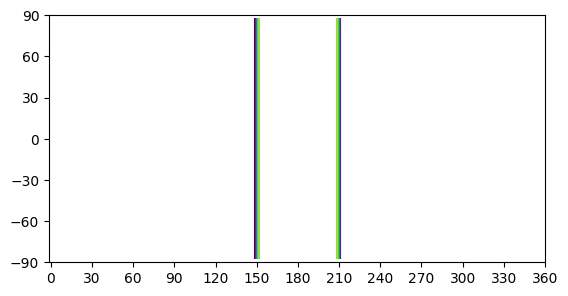

In [3]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir[0], exp_name, 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get two datasets, `ds_all`, one for ocean and one for land, for a given latitude bin.

In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = True
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [6]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
# season = 'summer'
season = 'all'

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Global
region = 'Global'
lat_min = 0
lat_max = 90

ds_all = {'land':[], 'ocean': []}
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
with tqdm(total=n_land*2, position=0, leave=True) as pbar:
    for j in range(n_land):
        ds_use = ds[j].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) < lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_use = ds_use.load()
        for surf in ['land', 'ocean']:
            ds_all[surf] += [ds_use.isel(lon_time=np.where(np.isin(ds_use.lon, np.unique(lon[surf])))[0])]
            pbar.update(1)

100%|██████████| 12/12 [00:03<00:00,  3.01it/s]


In [7]:
# Load in aquaplanet dataset
exp_aqua = 'tau_sweep/aquaplanet/'
ds = []
ds_aqua = isca_tools.load_dataset(exp_aqua + exp_name)[var_keep].sel(pfull=np.inf, method='nearest')
ds_aqua = ds_aqua.sel(time=slice(use_time_start, np.inf))
ds_aqua = ds_aqua.where((np.abs(ds_use.lat) < lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
ds_aqua = ds_aqua.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
ds_aqua = ds_aqua.load()

## Temperature vs Percentile Plots
Recreating Extended Data Figure 2, Figure 3 and Figure 2b of Byrne 2021.

In [8]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
surfaces = ['ocean', 'land']
n_surf = len(surfaces)
quant_plot = np.arange(1, 100)     # first value must be 0 so temp_quant[0] is the mean value
n_quant = len(quant_plot)
n_lat = len(ds_all['ocean'][0].lat)
lat_weights = np.cos(np.deg2rad(ds_all['ocean'][0].lat))     # latitude area weighting is just the cosine

# surface values corresponding to the average obove a given percentile in temperature
temp_quant2 = {'ocean': np.zeros((n_land, n_lat, n_quant)), 'land': np.zeros((n_land, n_lat, n_quant))}
temp_quant2_aqua = np.zeros((n_lat, n_quant))

with tqdm(total=n_land*n_surf*n_lat, position=0, leave=True) as pbar:
    for k in range(n_lat):
        temp_quant2_aqua[k] = ds_aqua.temp[k].quantile(quant_plot/100, dim='lon_time', keep_attrs=True)
        for j in range(n_land):
                for surf in surfaces:
                    temp_quant2[surf][j, k] = ds_all[surf][j].temp[k].quantile(quant_plot/100, dim='lon_time', keep_attrs=True)
                    pbar.update(1)

100%|██████████| 768/768 [00:04<00:00, 168.32it/s]


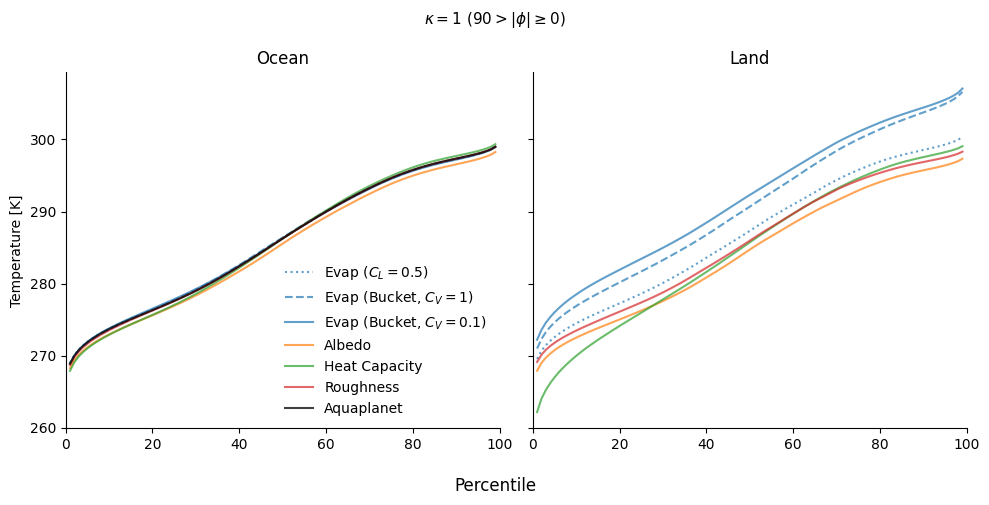

In [9]:
fig, ax = plt.subplots(1,n_surf, figsize=(10, 5), sharey=True, sharex=True)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyles = [':', '--', '-', '-', '-', '-']
land_color_ind = [0, 0, 0, 1, 2, 3]
for k, surf in enumerate(surfaces):
    ax[k].set_title(surf.capitalize())
    ax[k].spines[['right', 'top']].set_visible(False)
    for i in range(n_land):
        ax[k].plot(quant_plot, np.average(temp_quant2[surf][i], weights=lat_weights, axis=0), color=default_colors[land_color_ind[i]],
                   label=land_names[i], alpha=0.7, linestyle=linestyles[i])
ax[0].plot(quant_plot, np.average(temp_quant2_aqua, weights=lat_weights, axis=0), color='k', label='Aquaplanet', alpha=0.75)
ax[0].set_xlim(0,100)
ax[0].set_ylabel('Temperature [K]')
ax[0].legend(frameon=False)
fig.supxlabel('Percentile')
fig.suptitle(f'$\kappa={tau_lw[0]}$ (${lat_max}>|\phi| \geq {lat_min}$)', fontsize=11)
plt.tight_layout()

## Variation with Latitude
The plots below shows how a particular temperature percentile varies with latitude.

In [10]:
def abs_lat_av(var):
    # averages across indices with the same absolute latitude
    var_av = np.zeros(int(len(var)/2))
    for i in range(len(var_av)):
        var_av[i] = np.mean([var[i], var[-1-i]])
    return var_av[::-1]     # invert order so latitude is increasing

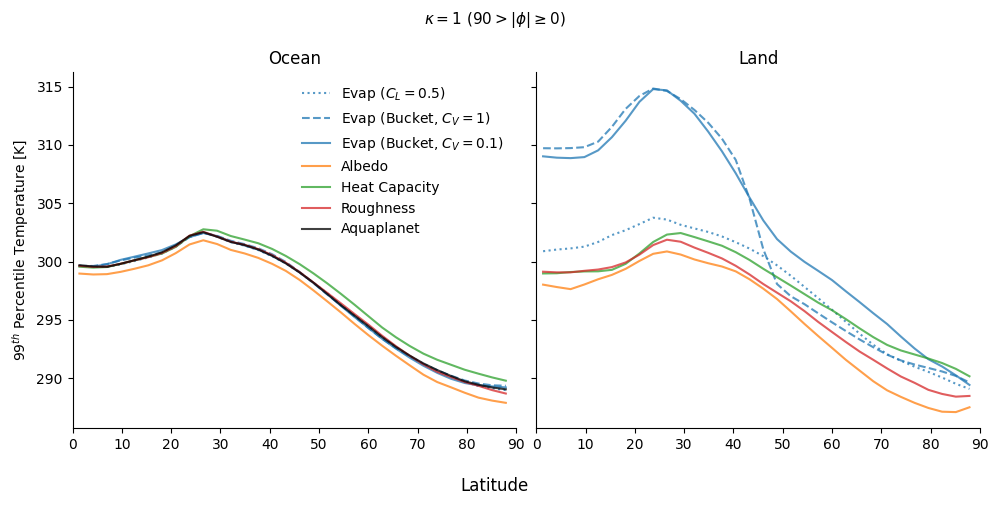

In [12]:
quant_subset = [99]
quant_subset_ind = numpy_indexed.indices(quant_plot, quant_subset)[0]
lat_plot = ds_all['ocean'][0].lat[int(n_lat/2):]

fig, ax = plt.subplots(1,n_surf, figsize=(10, 5), sharex=True, sharey=True)
for k, surf in enumerate(surfaces):
    ax[k].set_title(surf.capitalize())
    ax[k].spines[['right', 'top']].set_visible(False)
    for i in range(n_land):
        ax[k].plot(lat_plot, abs_lat_av(temp_quant2[surf][i, :, quant_subset_ind]),
                                     color=default_colors[land_color_ind[i]], alpha=0.75,
                                     label=land_names[i], linestyle=linestyles[i])
ax[0].plot(lat_plot, abs_lat_av(temp_quant2_aqua[:, quant_subset_ind]), color='k', label='Aquaplanet', alpha=0.75)
ax[0].set_xlim(0,90)
ax[0].set_ylabel(f'{quant_subset[0]}'+'$^{th}$ Percentile Temperature [K]')
ax[0].legend(frameon=False)
fig.supxlabel('Latitude')
fig.suptitle(f'$\kappa={tau_lw[0]}$ (${lat_max}>|\phi| \geq {lat_min}$)', fontsize=11)
plt.tight_layout()